**Shruthan Radhakrishna** (**sr73@illinois.edu**) 

**Team 52 - Project ID 65**

All Code at: https://github.com/shruthanr/dl4h


This notebook is designed to be run on Google Colab using a T4 GPU runtime

In [1]:
# Get project code
!git clone https://github.com/shruthanr/dl4h.git
%cd dl4h

Cloning into 'dl4h'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24 (delta 6), reused 20 (delta 5), pack-reused 0
Receiving objects: 100% (24/24), 6.91 KiB | 6.91 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/dl4h


# Introduction
<!-- This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->


**Background**

- This project aims to replicate the work in [[1]](https://pubmed.ncbi.nlm.nih.gov/33705321/) which aims to build a system for the *disease prediction* task of identify patients infected with COVID-19 using computed tomography (CT) scans.
- Such a model could aid medical professionals in faster diagnosis of COVID-19 by providing an additional data point on the likleihood of a patient having COVID-19 based on a simple CT scan.
- A major challenge to build such a system is the scarcity of annotated data. Valid concerns of confidentiality and privacy make large scale aggregation of such data difficult. A related challenge is the lack of diversity in the data since data is likely to have been from a few hospitals which are unlikley to capture the divesity in demographies of people around the world.
- A second challenge is the interpretability of the results. Uninterpretable results reduce confidence in the system when used in practice. Interpretable systems can aid further analysis/research on the relation between CT scans and COVID-19 diagnosis.
- While there is no clear state-of-the-art for COVID-19 detction using CT scans, most recent papers on predicting COVID-19 from either CT scans (3D) or Chest X-rays (2D) use some form of deep CNN model (like VGGNet, AlexNet, ResNet), and/or attention-based models like in  [[2]](https://www.mdpi.com/2078-2489/14/7/370)  [[3]](https://www.nature.com/articles/s41598-022-27266-9#citeas)   [[4]](https://www.sciencedirect.com/science/article/pii/S2665917422000265).

**Paper**

- The paper proposes a novel architecture in an attempt to maximize the amount of information extracted from the CT scans for downstream classification. Specifically,  uses a Feature Pyramid Network (FPN)  [[5]](https://arxiv.org/abs/1612.03144) along with a ResNet50 model  [[6]](https://arxiv.org/abs/1512.03385) to identify sub-images/objects (that may be potential lesions) in the CT scan image. The same ResNet50 model is used to extract features from the sub-images and relational features between the sub-images. These features are concatenated with some global features from the original CT-scan image (also extracted using the same shared ResNet50 model), and are used to predict if the given CT scan is likely to be of a COVID-19 patient. This architecture of using ResNet50 and FPN to extract features at different granularities is referred to as **DRENet**. Final predictions at the patient level are obtained by aggregating the prediction over each CT image slice of the patient.
- The paper claims its architecture perform better than other deep CNN models like VGG16, DenseNet, and ResNet, especially in terms ROC-AUC and Recall.
- Since data is scarce, it becomes important to maximize the amount of information extracted from each image. The propsed method using features at different granularities attempts to do the same.
- Authors provide their code at: https://github.com/SY575/COVID19-CT . The code in this project is adapted from their code and modified.

# Scope of Reproducibility:

For the task of binary classification into two classes - No COVID (class 0) and COVID (class 1):

1.   Hypothesis 1: DRENet (proposed in the paper) performs as well as is state in the paper i.e. achieves ROC-AUC of 0.95.
2.   Hypothesis 2: DRENet performs better than ResNet for the same task, as suggested in the paper.

The paper also releases results for 3-class classification into (i) COVID-19, (ii) having Bacteria Pneumonia, or (iii) being Healthy. However, the dataset for such classification is unavailable, and hence will not be replicated.

<!-- You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc) -->


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [2]:
# import  packages you need
import os
import pickle
import random
from datetime import datetime
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.misc
import torch
import torch.nn.functional as F
import torch.utils.data
import torchvision
from src import resnet, losses
from src.anchors import (cdds2attention_map, generate_default_anchor_maps,
                          hard_nms)
from src.data import SARS

from PIL import Image
from scipy.io import loadmat
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from torch import nn
from torch.autograd import Variable
from torch.nn import DataParallel
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms
from tqdm import tqdm

In [3]:
BATCH_SIZE = 4
PROPOSAL_NUM = 6
CAT_NUM = 6
INPUT_SIZE = (448, 448)
LR = 0.0008# 0.002
WD = 1e-4
EVAL_FREQ = 1
resume = ''
test_model = 'model.ckpt'
save_dir = './'
random.seed(0)

##  Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->

### Download Data

- Training, validation, and testing data were provided publicly by the authors in the GitHub repository. The same been stored in a Google Drive and are downloaded and de-compressed below.
- Statistics are provided in the section below
- The function processing the data is present in `src/data.py` in the GitHub repository cloned at the top of this notebook.




In [4]:
!gdown 1VTaYmrBvF75Keet8QuNRA8l5Lp5F-BHM
!gdown 1-KpQwPMM7RBQ7fVaYGS5GhBDaYfo821y
!gdown 1BxET9-am4YzmO-6cboVWpel6d0Yg3YE2

!unzip -q train.zip
!unzip -q val.zip
!unzip -q test.zip

Downloading...
From: https://drive.google.com/uc?id=1VTaYmrBvF75Keet8QuNRA8l5Lp5F-BHM
To: /content/dl4h/test.zip
100% 12.2M/12.2M [00:00<00:00, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-KpQwPMM7RBQ7fVaYGS5GhBDaYfo821y
To: /content/dl4h/train.zip
100% 24.2M/24.2M [00:00<00:00, 293MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BxET9-am4YzmO-6cboVWpel6d0Yg3YE2
To: /content/dl4h/val.zip
100% 24.2M/24.2M [00:00<00:00, 167MB/s]


In [5]:
# # RUN this cell once only
# Causing Inconsistent Behaviour - To Investigate
# import os
# import shutil

# for d in ['train', 'val', 'test']:
#     for label in ['no_nCoV', 'nCoV']:
#         people_lst = list(set([item.split('_')[0] for item in os.listdir(os.path.join(d, label))]))
#         people_lst = {people:f'{d}-{label}-{str(i).zfill(3)}'
#                       for i, people in enumerate(people_lst)}
#         for fn in os.listdir(os.path.join(d, label)):
#             new_fn = people_lst[fn.split('_')[0]]+'_'+'_'.join(fn.split('_')[1:])
#             shutil.move(
#                 os.path.join(d, label, fn),
#                 os.path.join(d, label, new_fn))

In [5]:
train_path = './train/'
val_path = './val/'
test_path = './test/'

train = SARS(root=train_path, is_train=True)
val = SARS(root=val_path, is_train=False)
test = SARS(root=test_path, is_train=False)



trainloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,
                                          shuffle=True, drop_last=False)
valloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)
testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                         shuffle=False, drop_last=False)

### Statistics

In [6]:
# Train - Val - Test Split
print("Training set size", len(train))
print("Validation set size", len(val))
print("Testing set size", len(test))

Training set size 1148
Validation set size 1148
Testing set size 567


- This train-val-test split sizes above is on the slice level and not person level. For each person, there are multiple slices (images) from the 3D CT scan. According to the paper, the train-val-test split size at the person level is 60-10-30%. The training, validation, and testing splits above are provided as separate zip files by the authors of the paper, and have been used directly in this project.

- The authors provide code to rename files (which is presented in a few cells above - commented out). It is cauing inconsistent behaviour on Colab and is currently commented out - I am investigating it. It causes the validation set size to be smaller than the training set size. If it continues to be inconsistent on Colab, I will upload a different version of train.zip, val.zip and test.zip after running that code locally, for the final report

- Label 0 represents cases of No COVID and label 1 represents cases of COVID


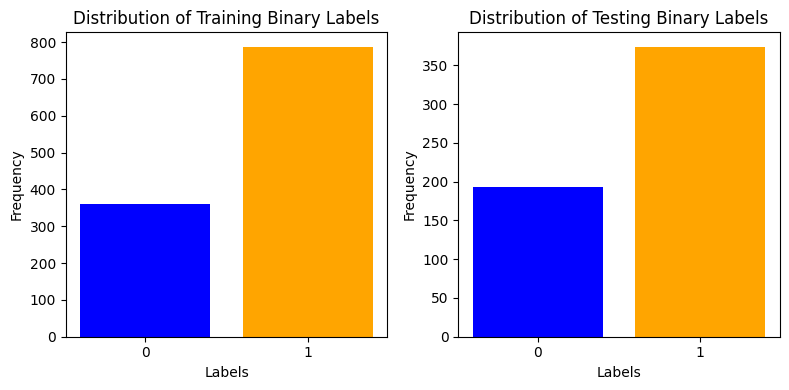

In [14]:
# Label distribution
train_labels = train.get_labels()
test_labels = test.get_labels()
train_unique_labels, train_label_counts = np.unique(train_labels, return_counts=True)
test_unique_labels, test_label_counts = np.unique(test_labels, return_counts=True)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].bar(train_unique_labels, train_label_counts, tick_label=train_unique_labels, color=['blue', 'orange'])
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Training Binary Labels')


axs[1].bar(test_unique_labels, test_label_counts, tick_label=test_unique_labels, color=['blue', 'orange'])
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Testing Binary Labels')

plt.tight_layout()
plt.show()

The labels aren't balanced. But the distribution of the training set matches the distribution of the testing set.

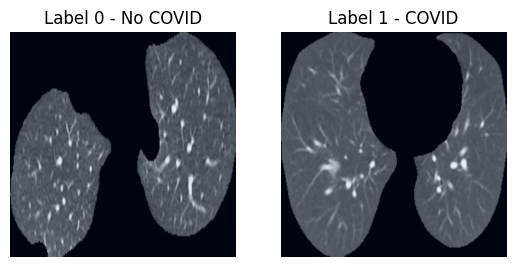

In [50]:
# Sample training images
image_0 = train[1][0].permute(1, 2, 0).numpy()
image_1 = train[0][0].permute(1, 2, 0).numpy()

image_norm_0 = (image_0 - np.min(image_0)) / (np.max(image_0) - np.min(image_0))
image_norm_1 = (image_1 - np.min(image_1)) / (np.max(image_1) - np.min(image_1))


# Display the images side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_norm_0, cmap='gray')
axes[0].set_title("Label 0 - No COVID")
axes[0].axis('off')
axes[1].imshow(image_norm_1, cmap='gray')
axes[1].set_title("Label 1 - COVID",)
axes[1].axis('off')
plt.show()

##   Model
This section contains the model definition and the traning loop. The training loop is **set to train for 1 epoch only** and is only for demonstration purposes. A model that has been more epochs (giving better performance) will be loaded later for evaluation and analysis.

### Model architecture

Please run the cells in this section for evaluation to work.

In [7]:
# Please RUN this cell
# An auxillary function
def get_xy(y0, x0, y1, x1, size=448):
    pad_size = size//2

    y0 = np.max([y0, pad_size])
    y0 = np.min([y0, size+pad_size])

    x0 = np.max([x0, pad_size])
    x0 = np.min([x0, size+pad_size])

    y1 = np.max([y1, pad_size])
    y1 = np.min([y1, size+pad_size])

    x1 = np.max([x1, pad_size])
    x1 = np.min([x1, size+pad_size])

    return y0, x0, y1, x1

In [8]:
# Please RUN this cell
# A part of the model
class ProposalNet(nn.Module):
    def __init__(self):
        super(ProposalNet, self).__init__()
        self.down1 = nn.Conv2d(2048, 128, 3, 1, 1)
        self.down2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.down3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.act = nn.ReLU()
        self.up1 = nn.Conv2d(128, 1, 1, 1, 0)
        self.up2 = nn.Conv2d(128, 1, 1, 1, 0)
        self.up3 = nn.Conv2d(128, 1, 1, 1, 0)

    def forward(self, x):
        batch_size = x.size(0)
        d1 = self.act(self.down1(x))
        d2 = self.act(self.down2(d1))
        d3 = self.act(self.down3(d2))
        t1 = self.up1(d1).view(batch_size, -1)
        t2 = self.up2(d2).view(batch_size, -1)
        t3 = self.up3(d3).view(batch_size, -1)
        return torch.cat((t1, t2), dim=1), t3

In [9]:
# Please RUN this cell
# Model architecture proposed in the paper
class DRENet(nn.Module):
    def __init__(self, top_k=4, n_class=2):
        super(DRENet, self).__init__()
        self.n_class = n_class
        self.pretrained_model = resnet.resnet50(pretrained=True)
        self.proposal_net = ProposalNet()
        self.top_k = top_k

        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.pretrained_model.fc = nn.Linear(512 * 4, self.n_class)
        self.concat_net = nn.Linear(2048 * (CAT_NUM + 1 + 1), self.n_class)
        self.subimg_net = nn.Linear(512 * 4, self.n_class)

        self.pad_size = 224
        _, edge_anchors_small, _ = generate_default_anchor_maps(setting='small')
        self.edge_anchors_small = (edge_anchors_small + 224).astype(int)
        _, edge_anchors_large, _ = generate_default_anchor_maps(setting='large')
        self.edge_anchors_large = (edge_anchors_large + 224).astype(int)

    def _func(self, x, rpn_score, edge_anchors):
        all_cdds = [
            np.concatenate((x.reshape(-1, 1),
                            edge_anchors.copy(),
                            np.arange(0, len(x)).reshape(-1, 1)), axis=1)
            for x in rpn_score.data.cpu().numpy()]
        top_n_cdds = np.array(
            [hard_nms(x, topn=self.top_k//2, iou_thresh=0.1) for x in all_cdds]
        )
        # top_n_cdds = np.array(top_n_cdds)
        top_n_index = top_n_cdds[:, :, -1].astype(int)
        top_n_index = torch.from_numpy(top_n_index).cuda()
        top_n_prob = torch.gather(rpn_score, dim=1, index=top_n_index)
        return top_n_cdds, top_n_prob


    def forward(self, x, img_raw, add=False, return_vis=False):
        resnet_out, rpn_feature, feature = self.pretrained_model(x)
        x_pad = F.pad(x, (self.pad_size, self.pad_size,
                          self.pad_size, self.pad_size), mode='constant', value=0)

        batch = x.size(0)

        # small
        rpn_score_small, rpn_score_large = self.proposal_net(rpn_feature.detach())
        top_n_cdds_small, top_n_prob_small = self._func(x, rpn_score_small, self.edge_anchors_small)
        top_n_cdds_large, top_n_prob_large = self._func(x, rpn_score_large, self.edge_anchors_large)

        part_imgs = torch.zeros([batch, self.top_k, 3, 224, 224]).cuda()
        for i in range(batch):
            for j in range(self.top_k//2):
                [y0, x0, y1, x1] = top_n_cdds_small[i][j, 1:5].astype(int)
                part_imgs[i:i + 1, j] = F.interpolate(
                    x_pad[i:i + 1, :, y0:y1, x0:x1],
                    size=(224, 224),
                    mode='bilinear',
                    align_corners=True)

                [y0, x0, y1, x1] = top_n_cdds_large[i][j, 1:5].astype(int)
                part_imgs[i:i + 1, j+self.top_k//2] = F.interpolate(
                    x_pad[i:i + 1, :, y0:y1, x0:x1],
                    size=(224, 224),
                    mode='bilinear',
                    align_corners=True)

        part_imgs = part_imgs.view(batch * self.top_k, 3, 224, 224)
        temp, _, sub_image_feats = self.pretrained_model(part_imgs.detach())
        sub_image_feat = sub_image_feats.view(batch, self.top_k, -1)
        sub_image_feat = sub_image_feat[:, :CAT_NUM, ...]
        sub_image_feat = sub_image_feat.contiguous().view(batch, -1)

        x2 = x.clone()
        if add:
            for bs in range(batch):
                [y0, x0, y1, x1] = top_n_cdds_large[bs][0, 1:5].astype(int)
                y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
                y0 = int((y0 - 224)/448*600)
                x0 = int((x0 - 224)/448*600)
                y1 = int((y1 - 224)/448*600)
                x1 = int((x1 - 224)/448*600)
                x2[bs] = F.interpolate(
                        img_raw[bs:bs + 1, :, y0:y1, x0:x1],
                        size=(448, 448),
                        mode='bilinear',
                        align_corners=True)
        _, _, feature2 = self.pretrained_model(x2.detach()) #

        # top_n_index = torch.cat([top_n_index_small, top_n_index_large], 1)
        top_n_prob = torch.cat([top_n_prob_small, top_n_prob_large], 1)

        concat_out = torch.cat([sub_image_feat, feature, feature2], dim=1)
        concat_logits = self.concat_net(concat_out)
        raw_logits = resnet_out# (resnet_out + att_logits) / 2
        # part_logits have the shape: B*N*200
        part_logits = self.subimg_net(sub_image_feats).view(batch, self.top_k, -1)
        top_n_index = None
        return [raw_logits, concat_logits, part_logits, top_n_index, top_n_prob]

### Training loop

Training can conviniently be performed using T4 GPU on Colab. It takes ~3 minutes per epoch of training.

The code below is only needed for training, not for evaluation

In [11]:
# Only RUN this cell to perform training, skip for evaluation
# Prepare for training
n_class = 2
net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class)
net = net.cuda()

creterion = torch.nn.CrossEntropyLoss()
parameters = list(net.parameters())
optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9, weight_decay=WD)
schedulers = [MultiStepLR(optimizer, milestones=[60, 100], gamma=0.1)]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [12]:
# Only RUN this cell to perform training, skip for evaluation

# Training for 1 epoch
skip_epoch = 0
best = 0

for epoch in range(0, 1):
    print("Epoch", epoch)
    if epoch > skip_epoch:
        add = True
    else:
        add = False
    for scheduler in schedulers:
        scheduler.step()

    net.train()
    train_correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader)):
        img, label, img_raw = data[0].cuda(), data[1].cuda(), data[2]
        batch_size = img.size(0)
        optimizer.zero_grad()
        raw_logits, concat_logits, part_logits, _, top_n_prob = net(img, img_raw, add)
        part_loss = losses.list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                    label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
        raw_loss = creterion(raw_logits, label)
        concat_loss = creterion(concat_logits, label)
        rank_loss = losses.ranking_loss(top_n_prob, part_loss)
        partcls_loss = creterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                 label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))

        total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
        total_loss.backward()
        optimizer.step()

        _, concat_predict = torch.max(concat_logits, 1)
        total += batch_size
        train_correct += torch.sum(concat_predict.data == label.data)

    print("training auc: ", float(train_correct) / total)
    pickle.dump(net, open('./model.pkl', 'wb'))
    if epoch % EVAL_FREQ == 0 :
        val_loss = 0
        val_correct = 0
        total = 0
        net.eval()
        auc_label_lst = []
        auc_pred_lst = []
        people_lst = []
        file_name_lst = []
        for i, data in enumerate(tqdm(valloader)):
            with torch.no_grad():
                img, label, img_raw = data[0].cuda(), data[1].cuda(), data[2]
                batch_size = img.size(0)
                _, concat_logits, _, _, _, = net(img, img_raw, add)
                concat_loss = creterion(concat_logits, label)
                _, concat_predict = torch.max(concat_logits, 1)
                auc_label_lst += list(label.data.cpu().numpy())
                pred = torch.nn.Softmax(1)(concat_logits)
                auc_pred_lst.append(pred.data.cpu().numpy())
                people_lst.append(data[3])
                file_name_lst.append(data[4])

                total += batch_size
                val_correct += torch.sum(concat_predict.data == label.data)
                val_loss += concat_loss.item() * batch_size

        val_acc = float(val_correct) / total
        val_loss = val_loss / total

        print(f'auc: {roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1]):.4f}')
        auc = roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1])
        if auc > best:
            best = auc
            pickle.dump(net, open(f'./val_best_model_{epoch}.pkl', 'wb'))
            torch.save(net.state_dict(), f'val_best_model_{epoch}.pt')


        np.save('./train_pred.npy', np.concatenate(auc_pred_lst, 0))
        np.save('./train_label.npy', np.array(auc_label_lst))
        np.save('./train_people.npy', np.concatenate(people_lst, 0))
        np.save('./train_file_name.npy', np.concatenate(file_name_lst, 0))

print('finished training')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0


  0%|          | 0/277 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 277/277 [02:29<00:00,  1.86it/s]


training auc:  0.6600361663652803


100%|██████████| 272/272 [00:50<00:00,  5.41it/s]


auc: 0.6813
finished training


# Results and Analysis



In [10]:
# Download pretrained model

# saves as best_7_model_3.pt
!gdown 11OupXwAML9TBDJXc8TpiVKl_k-u1xqZc

Downloading...
From (original): https://drive.google.com/uc?id=11OupXwAML9TBDJXc8TpiVKl_k-u1xqZc
From (redirected): https://drive.google.com/uc?id=11OupXwAML9TBDJXc8TpiVKl_k-u1xqZc&confirm=t&uuid=1845938a-170b-4647-81a7-d348cae10e07
To: /content/dl4h/best_7_model_3.pt
100% 105M/105M [00:00<00:00, 131MB/s] 


In [11]:
# Load pretrained network
n_class = 2
trained_net = DRENet(top_k=PROPOSAL_NUM, n_class=n_class)
trained_net.load_state_dict(torch.load('best_7_model_3.pt'))
trained_net = trained_net.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.0MB/s]


In [12]:
# Evaluate on test set
test_loss = 0
test_correct = 0
total = 0
auc_label_lst = []
auc_pred_lst = []
people_lst = []
img_vis_lst = []
file_name_lst = []
anchor_lst = []
add=False
torch.manual_seed(101)
for i, data in enumerate(tqdm(testloader)):
    with torch.no_grad():
        img, label, img_raw = data[0].cuda(), data[1].cuda(), data[2]
        batch_size = img.size(0)
        _, concat_logits, _, _, _ = trained_net(img, img_raw, add, False)
        _, concat_predict = torch.max(concat_logits, 1)
        auc_label_lst += list(label.data.cpu().numpy())
        pred = torch.nn.Softmax(1)(concat_logits)
        auc_pred_lst.append(pred.data.cpu().numpy())
        people_lst.append(data[3])
        file_name_lst += list(data[4])
        total += batch_size
        test_correct += torch.sum(concat_predict.data == label.data)
test_acc = float(test_correct) / total


pred_logits = np.concatenate(auc_pred_lst, 0)[:, 1]
print(f'\nauc: {roc_auc_score(auc_label_lst, pred_logits):.4f}')

100%|██████████| 142/142 [00:35<00:00,  3.95it/s]


auc: 0.8882


We use the standard classification metrics - Precision, Recall, F1-score, and ROC-AUC. As shown in the data statistics section, the data is relatively unbalanced, making accuracy slightly unreliable as a metric.

In [13]:
# Classification Metrics
prediction = (pred_logits > 0.5).astype(int)
print(classification_report(auc_label_lst, prediction))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73       193
           1       0.83      0.96      0.89       374

    accuracy                           0.84       567
   macro avg       0.86      0.79      0.81       567
weighted avg       0.85      0.84      0.84       567



We see a high Recall for the COVID class (class 1). This is great as it means the number of actual COVID patients who will miss treatment (due to misprediction) will be low (though ideally we want it to be 0).

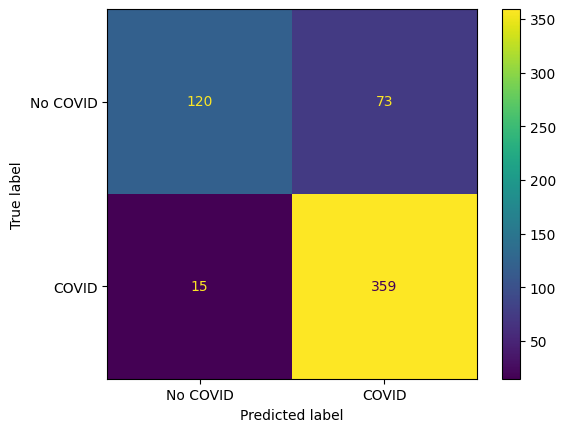

In [14]:
# Confusion Matrix
cm = confusion_matrix(auc_label_lst, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No COVID", "COVID"])
disp.plot()
plt.show()

**Note**: The confusion matrix above is at the slice/image-level while the confusion matrix in the paper is at the person-level and not slice-level. ROC-AUC scores in the paper however appear to be at the slice/image level. I'm yet to do any person-level evaluation.

In [15]:
# ROC-AUC - target metric
print(f'ROC-AUC: {roc_auc_score(auc_label_lst, pred_logits):.4f}')

ROC-AUC: 0.8882


The ROC-AUC, while good,  is lower than reported in the paper (0.95). The next step is to work towards increasing the ROC-AUC to match the paper's result

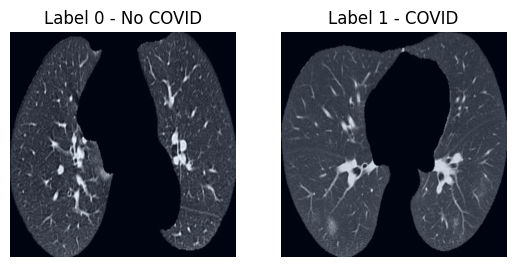

In [30]:
# Sample testing images
image_0 = test[3][0].permute(1, 2, 0).numpy()
image_1 = test[0][0].permute(1, 2, 0).numpy()

image_norm_0 = (image_0 - np.min(image_0)) / (np.max(image_0) - np.min(image_0))
image_norm_1 = (image_1 - np.min(image_1)) / (np.max(image_1) - np.min(image_1))


# Display the images side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image_norm_0, cmap='gray')
axes[0].set_title("Label 0 - No COVID")
axes[0].axis('off')
axes[1].imshow(image_norm_1, cmap='gray')
axes[1].set_title("Label 1 - COVID",)
axes[1].axis('off')
plt.show()

## Model comparison

In [ ]:
# TODO in Final Project Report

# Discussion

<!-- In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase. -->



- This paper is reproducible for the binary classification task.
- Hypothesis 1 has been tested. The results (at this stage) seem to be slightly below the results in the paper. There might be two factors affecting performance - (1) I have used a single optimizer in the training loop, whereas the code provided seems to provide a separate optimizer for each loss function. The effect of this has to be studied (2) There are multiple hyperparameters that can be changed, and further experimentation with different hyperparameters might yield better performance
- While code from authors is available, it doesn't seem to be the best-written code. I am importing and reorganizing only the code essential for training and evaluation as a part of my submission.



## Next Steps


- Implement pooling accross slices to get person level predictions
- Experiment with hyperparameters in an attempt to reach performance stated in paper in terms of ROC-AUC scores.
- Implement the baseline model (ResNet) for comparision to test Hypothesis 2.
- Ablation study - the proposed architecture uses three types of features (sub-image, global, relational). An ablation study would involve evaluating performance on individually omitting each feature.
- Modularize the current codebase
- (Stretch) Visualization for interpretability of results

In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# References

1.  Song, Ying et al. “Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With CT Images.” IEEE/ACM transactions on computational biology and bioinformatics vol. 18,6 (2021): 2775-2780. doi:10.1109/TCBB.2021.3065361

2. Kuzinkovas, D.; Clement, S. The Detection of COVID-19 in Chest X-rays Using Ensemble CNN Techniques. Information 2023, 14, 370. https://doi.org/10.3390/info14070370

3. Ullah, Z., Usman, M., Latif, S. et al. Densely attention mechanism based network for COVID-19 detection in chest X-rays. Sci Rep 13, 261 (2023). https://doi.org/10.1038/s41598-022-27266-9

4. A. Arivoli, Devdatt Golwala, Rayirth Reddy,
CoviExpert: COVID-19 detection from chest X-ray using CNN,
Measurement: Sensors,
Volume 23,
2022,
100392,
ISSN 2665-9174,
https://doi.org/10.1016/j.measen.2022.100392.


5.   Lin T.-Y. et al. “Feature pyramid networks for object detection,” in Proc. IEEE Conf. Comput. Vis. Pattern Recognit., 2017, pp. 936–944.

6.  K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.

